In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

In [2]:
%cd '/Users/akbaskind/Documents/Python Scripts/phyto'
%run PLT.py

/Users/akbaskind/Documents/Python Scripts/phyto


# Pull Data

In [3]:
#The scope is always look like this so we did not need to change anything

import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

# Name of our Service Account Key
google_key_file = 'servicecredentials.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Spreadsheet key
spreadsheet_key = '1uLRAvFDsTSfS-c45DiG-W6VMa8I1J7XD1O-pJA4fp10'

# Worksheet keys
wks_hydrocat620 = 'Hydrocat 620'
wks_hydrocat720 = 'Hydrocat 720'
wks_MV = 'MV'
wks_QP = 'QP'

#Opening the worksheet by using Worksheet ID
workbook = gc.open_by_key(spreadsheet_key)

## HYDROCAT 620
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat620)
values = sheet.get_all_values()
hydrocat620 = pd.DataFrame(values[1:], columns = values[0])


## HYDROCAT 720
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_hydrocat720)
values = sheet.get_all_values()
hydrocat720 = pd.DataFrame(values[1:], columns = values[0])

## MV
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_MV)
values = sheet.get_all_values()
MV = pd.DataFrame(values[1:], columns = values[0])

## QP
#Selecting which sheet to pulling the data
sheet = workbook.worksheet(wks_QP)
values = sheet.get_all_values()
QP = pd.DataFrame(values[1:], columns = values[0])

In [4]:
for k in hydrocat620.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat620[k] = pd.to_datetime(hydrocat620[k])
    else:
        hydrocat620[k] = pd.to_numeric(hydrocat620[k])

for k in hydrocat720.keys():
    if k == 'DateTime' or k == 'time':
        hydrocat720[k] = pd.to_datetime(hydrocat720[k])
    else:
        hydrocat720[k] = pd.to_numeric(hydrocat720[k])
        
for k in QP.keys():
    if k == 'DateTime' or k == 'time':
        QP[k] = pd.to_datetime(QP[k])
    else:
        QP[k] = pd.to_numeric(QP[k])
        
for k in MV.keys():
    if k == 'DateTime' or k == 'time':
        MV[k] = pd.to_datetime(MV[k])
    else:
        MV[k] = pd.to_numeric(MV[k])

In [169]:
for k in metdf.keys():
    if k == 'DateTime':
        metdf[k] = pd.to_datetime(metdf[k], format = '%Y-%m-%D %H:%M:%S')

In [188]:
df = hydrocat620.where(hydrocat620['DateTime'] > datetime(2023, 2, 10)).where(hydrocat620['DateTime'] < datetime(2023, 2, 28)).dropna()
df = df.reset_index(drop = True)

In [168]:
k

'TmStamp'

# Decomposition
$$
\Delta [\text{H}^+] \approx \frac{\partial [\text{H}^+]}{\partial \text{T}} \Delta \text{T} 
+ \frac{\partial [\text{H}^+]}{\partial \text{S}} \Delta \text{S} 
+ \frac{\partial [\text{H}^+]}{\partial \text{TA}} \Delta \text{TA} 
+ \frac{\partial [\text{H}^+]}{\partial \text{DIC}} \Delta \text{DIC}_{\text{bio}} 
+ \frac{\partial [\text{H}^+]}{\partial \text{DIC}} \Delta \text{DIC}_{\text{flux}} 
+ \frac{\partial [\text{H}^+]}{\partial \text{DIC}} \Delta \text{DIC}_{\text{mix}} 
$$

Each term in this equations consists of (A) a partial derivative of H+ in terms of *variable* and (B) the discrete time change of *variable*.


In [220]:
def decomposition(df, timeslice):
    # Basic packages
    import numpy as np
    from matplotlib import pyplot as plt
    import xarray as xr
    import pandas as pd
    import math

    # DateTime packages
    from matplotlib.dates import DateFormatter
    from datetime import datetime, timedelta
    import time
    import matplotlib.dates as mdates

    # Stats/science packages
    import scipy
    import PyCO2SYS as pyco2
    import gsw
    
    # Check if `timeslice` is an appropriate selection-------------------------------------------------
    if timeslice != 'D' and timeslice != 'W' and timeslice != 'Y' and timeslice != 'M':
        print('Please select "D," "W," "M," or "Y" for day, week, month, or year.')
        return
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    # Check that the DataFrame has all the necessary inputs--------------------------------------------
    # # DateTime
    if not 'DateTime' in df.keys():
        print('Please ensure your dataframe has a column named "DateTime".')
        return
    # # Temperature
    if not 'Temperature [degC]' in df.keys():
        print('Please ensure your dataframe has a column for temperature named "Temperature [degC]".')
        return
    # # Salinity
    if not 'Salinity [PSU]' in df.keys():
        print('Please ensure your dataframe has a column for salinity named "Salinity [PSU]".')
        return
    # # pH
    if not 'pH final' in df.keys():
        print('Please ensure your dataframe has a column for pH named "pH final".')
        return
    # -------------------------------------------------------------------------------------------------
    
    # ************************************************************************************************* 
    
    # Take daily/weekly/monthly/yearly mean and standard error-----------------------------------------
    MN = df.resample(timeslice, on='DateTime').mean()
    STD = df.resample(timeslice, on='DateTime').std(ddof = 1)
    # -------------------------------------------------------------------------------------------------
    
    # ************************************************************************************************* 
    
    # Optional input for wind speed--------------------------------------------------------------------
    # # If wind speed not provided, default U10 to 3 m/s
    if not 'avgWindSpeed' in MN.keys():
        print('Your dataframe does not include a column for wind speed labeled as "avgWindSpeed." Default U10 wind speed is set to 3 m/s.')
        U10 = 3
    # # If wind speed is provided, use that for U10 speed
    else:
        U10 = MN['avgWindSpeed']
    # -------------------------------------------------------------------------------------------------
    
    # ************************************************************************************************* 
    
    # pH ERROR-----------------------------------------------------------------------------------------
    # # Calculate error in pH arising from both instrumental error and error from averaging
    STD['pH instrumemnt error'] = 0.1
    STD['pH total error'] = np.sqrt(STD['pH final']**2 + STD['pH instrumemnt error']**2)
    # -------------------------------------------------------------------------------------------------
    
    # ************************************************************************************************* 
    
    # SOLVE CARBONATE SYSTEM---------------------------------------------------------------------------
    pH = MN['pH final']                             # pH
    dpH = STD['pH total error']                     # pH error
    dT = STD['Temperature [degC]']                  # Temperature error (from averaging)
    dS = STD['Salinity [PSU]']                      # Salinity error (from averaging)
    S = MN['Salinity [PSU]']                        # Salinity
    T = MN['Temperature [degC]']                    # Temperature
    
    # Alkalinity calculation
    TA = 477.62 + 51.99 * MN['Salinity [PSU]']      # Pimenta et al., 2023    
    MN['Alkalinity [umol/kg]'] = TA                 # Alkalinity
    dTA = dS * 51.99                                # Alkalinity error (arising from salinity average)
    STD['Alkalinity'] = dTA                         # Alkalinity error

    results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S,
                        # Calculate uncertainities of...
                        uncertainty_into =["alkalinity", "dic","Hfree", 'pCO2'],
                        # Sources of uncertainty: pH, T, S, and TA
                        uncertainty_from ={"par2": dpH, 'temperature': dT, 'salinity': dS, 'par1': dTA})
    
    MN['H+ [umol/kg]'] = results['Hfree']           # H+ concentration
    MN['DIC [umol/kg]'] = results['dic']            # DIC
    MN['pCO2 [ppm]'] = results['pCO2']              # pCO2

    STD['H+ [umol/kg]'] = results['u_Hfree']        # H+ error (from TA, pH, S, and T)
    STD['DIC [umol/kg]'] = results['u_dic']         # DIC error (from TA, pH, S, and T)
    STD['pCO2'] = results['u_pCO2']                 # pCO2 error (from TA, pH, S, and T)
    # -------------------------------------------------------------------------------------------------
    
    # ************************************************************************************************* 

    # Re-solve carb system using TA and DIC (total)----------------------------------------------------
    # # Calculate gradients of H+
    DIC = MN['DIC [umol/kg]']
    dDIC = STD['DIC [umol/kg]']
    results = pyco2.sys(par1 = DIC, par2 = TA, par1_type = 2, par2_type = 1, temperature = T, salinity = S,
                        # Take grad of H+
                        grads_of=["Hfree"],
                        # In terms of par1 (which is DIC)
                        grads_wrt=["par1", 'temperature', 'salinity', 'par2'],
                        uncertainty_into =["pCO2", "Hfree"],
                        uncertainty_from ={"par1": dDIC})

    MN['∂H/∂DIC'] = results['d_Hfree__d_par1']      # ∂H/∂DIC
    MN['∂H/∂TA'] = results['d_Hfree__d_par2']       # ∂H/∂TA
    MN['∂H/∂T'] = results['d_Hfree__d_temperature'] # ∂H/∂T
    MN['∂H/∂S'] = results['d_Hfree__d_salinity']    # ∂H/∂S
    
    # Error in H+ arising from uncertainty in TA, DIC, T, S, and pH
    STD['H+ [umol/kg]'] = results['u_Hfree']
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    # Finite differences-------------------------------------------------------------------------------
    MN['∆DIC'] = MN['DIC [umol/kg]'].diff()
    MN['∆TA'] = MN['Alkalinity [umol/kg]'].diff()
    MN['∆T'] = MN['Temperature [degC]'].diff()
    MN['∆S'] = MN['Salinity [PSU]'].diff()
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    # DIC mixing---------------------------------------------------------------------------------------
    # # Based on the relationship presented in Pimenta et al (2023)
    # # 397.65 + 50.59 * S = DIC
    MN['∆DIC_mix'] = (MN['Salinity [PSU]'] * 50.59).diff()
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    # DIC air sea flux---------------------------------------------------------------------------------
    # # t for conversion based on timeslice
    if timeslice == 'D':
        t = 365.25
    elif timeslice == 'M':
        t = 12
    elif timeslice == 'W':
        t = 52
        
    # # Requires functions 
    # #        - co2flux(pco2_sea, pco2_air, sst, sss, wspd)
    # #        - K0_Weiss(sst,sss)
    # #        - gas_transfer_velocity(sst,wspd)
    
    # molC/m2/yr
    fgco2_ann = co2flux(MN['pCO2 [ppm]'], 410, MN['Temperature [degC]'], MN['Salinity [PSU]'], U10)
    # molC/m2/month or molC/m2/day or...
    fgco2_month = fgco2_ann/t
    # Assumed mixed layer depth of 9m
    MLD = 9
    # Density [kg/m3]
    rho = gsw.rho(MN['Salinity [PSU]'].to_numpy(), MN['Temperature [degC]'].to_numpy(), np.zeros(len(MN)))
    # umolC/kg/month
    MN['DIC_flux [umolC/L]'] = -(fgco2_month/MLD)*(1e6)/rho
    # finite difference
    MN['∆DIC_flux [umolC/L]'] = MN['DIC_flux [umolC/L]'].diff()
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************

    # DIC bio------------------------------------------------------------------------------------------
    MN['∆DIC_bio [umolC/L]'] = MN['∆DIC'] - MN['∆DIC_flux [umolC/L]'] - MN['∆DIC_mix']
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    # TA bio-------------------------------------------------------------------------------------------
    # Converts DIC bio to TA bio using the Redfield ratio (i.e. -16/107)
    MN['∆TA_bio [umolC/L]']=MN['∆DIC_bio [umolC/L]']*(-16/107)
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    # TA mixing----------------------------------------------------------------------------------------
    # Based on the relationship presented in Pimenta et al (2023)
    # 477.62 + 51.99 * S = TA
    MN['∆TA_mix [umolC/L]'] = (MN['Salinity [PSU]'] * 51.59).diff()
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    # Calculate components-----------------------------------------------------------------------------
    temp = MN['∂H/∂T'] * MN['∆T']                          # Temperature
    sal = MN['∂H/∂S'] * MN['∆S']                           # salinity
    alk_mix = MN['∂H/∂TA'] * MN['∆TA_mix [umolC/L]']       # TA mixing
    alk_bio = MN['∂H/∂TA'] * MN['∆TA_bio [umolC/L]']       # TA bio
    dic_bio = MN['∂H/∂DIC'] * MN['∆DIC_bio [umolC/L]']     # DIC bio
    ASF = MN['∂H/∂DIC'] * MN['∆DIC_flux [umolC/L]']        # DIC air sea flux
    dic_mix = MN['∂H/∂DIC'] * MN['∆DIC_mix']               # DIC mixing
    BIO = dic_bio + alk_bio                                # Total bio = DIC bio + TA bio
    MIX = dic_mix + alk_mix                                # Total mixing = DIC mixing + TA mixing
    TOT = temp + sal + ASF + BIO + MIX                     # Total
    
    # DataFrame containing all the components
    data = {'DateTime': MN.index,
            'Temperature': temp,
            'Salinity': sal,
            'TA mixing': alk_mix,
            'TA bio': alk_bio,
            'DIC mixing': dic_mix,
            'DIC_bio': dic_bio,
            'DIC air sea flux': ASF,
            'Total bio': BIO,
            'Total mixing': MIX,
            'Total': TOT}
    dH_component = pd.DataFrame(data)
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    # Calculate errors of components-------------------------------------------------------------------
    YERR = {'DateTime': [],
            'Temperature': [],
            'Salinity': [],
            'TA mixing': [],
            'TA bio': [],
            'DIC mixing': [],
            'DIC bio': [],
            'DIC ASF': [],
            'Total bio': [],
            'Total mixing': [],
            'Total error': []}
    # Error of each component
    # ∆z = z √[(∆x/x)^2 + (∆y/y)^2]
    YERR['Temperature'] = temp * np.sqrt((STD['Temperature [degC]']/MN['Temperature [degC]'])**2
                                         + (STD['H+ [umol/kg]']/MN['H+ [umol/kg]'])**2)
    YERR['Salinity'] = sal * np.sqrt((STD['Salinity [PSU]']/MN['Salinity [PSU]'])**2
                                     + (STD['H+ [umol/kg]']/MN['H+ [umol/kg]'])**2)
    YERR['TA mixing'] = alk_mix * np.sqrt((STD['Alkalinity']/MN['Alkalinity [umol/kg]'])**2
                                          + (STD['H+ [umol/kg]']/MN['H+ [umol/kg]'])**2)
    YERR['TA bio'] = alk_bio * np.sqrt((STD['Alkalinity']/MN['Alkalinity [umol/kg]'])**2
                                       + (STD['H+ [umol/kg]']/MN['H+ [umol/kg]'])**2)
    YERR['DIC bio'] = dic_bio * np.sqrt((STD['DIC [umol/kg]']/MN['DIC [umol/kg]'])**2
                                        + (STD['H+ [umol/kg]']/MN['H+ [umol/kg]'])**2)
    YERR['DIC mixing'] = dic_mix * np.sqrt((STD['DIC [umol/kg]']/MN['DIC [umol/kg]'])**2
                                           + (STD['H+ [umol/kg]']/MN['H+ [umol/kg]'])**2)
    YERR['DIC ASF'] = ASF * np.sqrt((STD['DIC [umol/kg]']/MN['DIC [umol/kg]'])**2
                                    + (STD['H+ [umol/kg]']/MN['H+ [umol/kg]'])**2)
    YERR['Total bio'] = np.sqrt(YERR['DIC bio']**2 + YERR['TA bio']**2)
    YERR['Total mixing'] = np.sqrt(YERR['DIC mixing']**2 + YERR['TA mixing']**2)
    YERR['DateTime'] = MN.index
    
    TOTERR_ = 0
    for k in YERR.keys():
        if k != 'Total bio' and k != 'Total mixing' and k!= 'Total error' and k != 'DateTime':
            TOTERR_ += YERR[k]**2
    TOTAL_ERROR = np.sqrt(TOTERR_)
    YERR['Total error'] = TOTAL_ERROR
    
    dH_errors = pd.DataFrame(YERR)
    # -------------------------------------------------------------------------------------------------
    
    # *************************************************************************************************
    
    return dH_component, dH_errors

In [222]:
[a,b] = decomposition(DF, 'D')
b.keys()

Index(['DateTime', 'Temperature', 'Salinity', 'TA mixing', 'TA bio',
       'DIC mixing', 'DIC bio', 'DIC ASF', 'Total bio', 'Total mixing',
       'Total error'],
      dtype='object')

<BarContainer object of 18 artists>

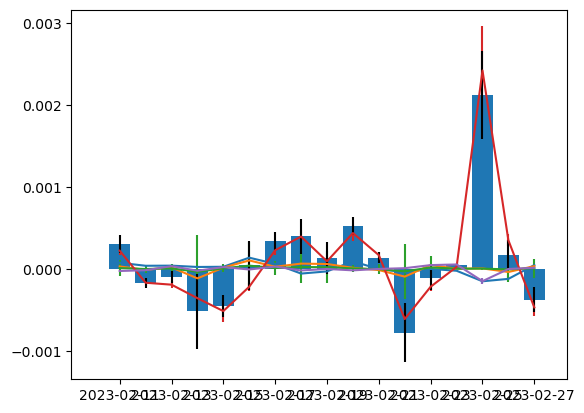

In [219]:
fig, ax = plt.subplots()

ax.errorbar(a['DateTime'], a['Temperature'], yerr = b['Temperature'])
ax.errorbar(a['DateTime'], a['Salinity'], yerr = b['Salinity'])
ax.errorbar(a['DateTime'], a['Total mixing'], yerr = b['Total mixing'])
ax.errorbar(a['DateTime'], a['Total bio'], yerr = b['Total bio'])
ax.errorbar(a['DateTime'], a['DIC air sea flux'], yerr = b['DIC ASF'])
ax.bar(a['DateTime'], a['Total'], yerr = b['Total error'])

In [184]:
df = df_.resample('D', on='DateTime').mean()
df_std = df_.resample('D', on='DateTime').std(ddof = 1)

In [189]:
DF = pd.merge_asof(metdf, df, on="DateTime",tolerance = pd.Timedelta("10m")).dropna()

## Error propagation: pH
The monthly means of pH have 2 sources of error. First is the instrumental error of 0.1. Second is the error arising from taking a monthly mean. For each monthly average, a standard error has already been calculated; we must combine that with the instrumental error. My best guess as to how this error is propagated is as follows:


$\sigma_{\text{avg}}$ is the error arising from taking an average.
$\sigma_{\text{meas}}$ is the error arising from the pH sensor.

$$
\sqrt{\sigma_{\text{avg}}^2 + \sigma_{\text{meas}}^2}
$$

In [104]:
df_std['pH instrumemnt error'] = 0.1
df_std['pH total error'] = np.sqrt(df_std['raw pH [total]']**2 + df_std['pH instrumemnt error']**2)

## Error propagation: TA
Error in TA arises from salinity. My best guess as to how this error is propagated is as follows:

$$
51.99 * \sigma_{\text{Sal}} = \sigma_{\text{TA}}
$$

## Error propagation: T and S
The errors in T and S arise from taking monthly averages.

## Error propagation: DIC
We can calculate the error in DIC from PyCO2SYS.

In [105]:
TA = 477.62 + 51.99 * df['Salinity [PSU]']
df['Alkalinity [umol/kg]'] = TA
pH = df['pH final']
dpH = df_std['pH total error']
dT = df_std['Temperature [degC]']
dS = df_std['Salinity [PSU]']
dTA = dS * 51.99
df_std['Alkalinity'] = dTA
S = df['Salinity [PSU]']
T = df['Temperature [degC]']

results = pyco2.sys(par1 = TA, par2 = pH, par1_type = 1, par2_type = 3, temperature = T, salinity = S,
                   uncertainty_into =["alkalinity", "dic","Hfree", 'pCO2'],
                   uncertainty_from ={"par2": dpH, 'temperature': dT, 'salinity': dS, 'par1': dTA})

In [106]:
df['H+ [umol/kg]'] = results['Hfree']
df['DIC [umol/kg]'] = results['dic']
df['pCO2 [ppm]'] = results['pCO2']

df_std['H+ [umol/kg]'] = results['u_Hfree']
df_std['DIC [umol/kg]'] = results['u_dic']
df_std['pCO2'] = results['u_pCO2']

## Step 2. Calculate the finite differences and partial derivatives
### Step 2a. Partial derivatives
I re-solve the carbonate system using TA and calculated DIC. I take the gradient of H+ with respect to (i.e. *wrt*) `par1` (in this case, DIC), `par2` (in this case, TA), temperature, and salinity. I add those to my table.

In [107]:
TA = 477.62 + 51.99 * df['Salinity [PSU]']
df['Alkalinity [umol/kg]'] = TA
DIC = df['DIC [umol/kg]']
dDIC = df_std['DIC [umol/kg]']
# dTA = H620_std['Alkalinity'] The error is TA has already been accounted for
pH = df['pH final']
S = df['Salinity [PSU]']
T = df['Temperature [degC]']

# Re-solve carb system using TA and DIC (total)
results = pyco2.sys(par1 = DIC, par2 = TA, par1_type = 2, par2_type = 1, temperature = T, salinity = S,
                    # Take grad of H+
                    grads_of=["Hfree"],
                    # In terms of par1 (which is DIC)
                    grads_wrt=["par1", 'temperature', 'salinity', 'par2'],
                    uncertainty_into =["pCO2", "Hfree"],
                    uncertainty_from ={"par1": dDIC})

df['∂H/∂DIC'] = results['d_Hfree__d_par1']
df['∂H/∂TA'] = results['d_Hfree__d_par2']
df['∂H/∂T'] = results['d_Hfree__d_temperature']
df['∂H/∂S'] = results['d_Hfree__d_salinity']


## Error propagation: [H+]

The error in [H+] comes from
1. pH
2. Alkalinity
3. T
4. S
5. DIC

In calculating DIC and its error, we have already accounted for errors in pH, TA, T, and S. Now we must also implement the error in DIC to get the error in [H+].

In [108]:
df_std['H+ [umol/kg]'] = results['u_Hfree']

### Step 2b. Finite differences
I use `np.diff()` to do this. It is the difference in a variable over out time step.

In [109]:
df['∆DIC'] = df['DIC [umol/kg]'].diff()
df['∆TA'] = df['Alkalinity [umol/kg]'].diff()
df['∆T'] = df['Temperature [degC]'].diff()
df['∆S'] = df['Salinity [PSU]'].diff()

## Step 2. DIC mixing 
### Step 2a. Calculate ∆DIC mixing
We estimated this using the relationship between DIC and salinity from Pimenta et al. (2023). This says for every 1 PSU increase in salinity, DIC increases by 50.59 umol/kg.

$$
\text{DIC}_{\text{mix}} = 397.65 + 50.59 \times \text{S}
$$

In [110]:
df['∆DIC_mix'] = (df['Salinity [PSU]'] * 50.59).diff()

### Step 2b. Calculate ∆DIC_ASF
First, we calculate the air-sea flux of CO2. Functions are provided and yield units of molC/m2/yr. Ultimately, we want units of umol/kg/month, so we convert.

To get ∆DIC_ASF, we simply differentiate.

In [37]:
def co2flux(pco2_sea, pco2_air, sst, sss, wspd):
    """
    Inputs
        - pCO2_sea [uatm] or [ppm]
        - pCO2_air [uatm] or [ppm]
        - SST [°C]
        - SSS [PSU]
        - wind speed [m/s?]
    Output
        - CO2 upward flux [molC/m2/yr] 
    """
    kt = gas_transfer_velocity(sst,wspd)
    K0 = K0_Weiss(sst,sss)
    dpco2 = pco2_sea - pco2_air
    co2_flux = kt * K0 * dpco2 * (24*365/100000) # Because kt is in cm/hour, pCO2 is in µatm, flux in most case is in mol C/m2/yr
    return co2_flux

def K0_Weiss(sst,sss):
    sst = sst + 273.15 # transfer to Kelvin degree
    A1 =-58.0931
    A2 = 90.5069
    A3 = 22.294
    B1 = 0.027766
    B2 = -0.025888
    B3 = 0.0050578
    ln_K0 = A1 + A2 * (100/sst) + A3 * np.log(sst/100) + sss * (B1 + B2 * (sst/100) + B3 * (sst/100)**2)
    K0 = np.exp(ln_K0)
    return K0

def gas_transfer_velocity(sst,wspd):
    A = 2116.8 
    B = -136.25
    C = 4.7353
    D = -0.092307
    E = 0.000755
    c = 0.251
    Sc = A + B*(sst) + C*(sst**2) + D*(sst**3) + E*(sst**4) # Jähne et al. (1987), Wanninkhof 2014
    kt = c * wspd**2 *((Sc/660)**(-0.5)) # unit: cm/hour
    return kt

In [113]:
# molC/m2/yr
fgco2_ann = co2flux(df['pCO2 [ppm]'], 410, df['Temperature [degC]'], df['Salinity [PSU]'], met['avgWindSpeed'])
# molC/m2/month
fgco2_month = fgco2_ann/12
MLD = 9
# Density [kg/m3]
rho = gsw.rho(df['Salinity [PSU]'].to_numpy(), df['Temperature [degC]'].to_numpy(), np.zeros(len(df)))
# umolC/kg/month
df['DIC_flux [umolC/L]'] = -(fgco2_month/MLD)*(1e6)/rho
df['∆DIC_flux [umolC/L]'] = df['DIC_flux [umolC/L]'].diff()
df

,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Alkalinity [umol/kg],H+ [umol/kg],DIC [umol/kg],...,∂H/∂TA,∂H/∂T,∂H/∂S,∆DIC,∆TA,∆T,∆S,∆DIC_mix,DIC_flux [umolC/L],∆DIC_flux [umolC/L]
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-02-10,3.993681,28.562519,11.568617,8.360527,0.020957,8.194335,8.008223,1962.585371,0.005740,1815.975092,...,-0.000036,0.000214,0.000186,NaN,NaN,NaN,NaN,NaN,48.251883,NaN
2023-02-11,4.319100,28.705128,11.185073,8.319690,0.022385,8.174143,7.994173,1969.999611,0.006003,1827.359539,...,-0.000038,0.000222,0.000192,11.384447,7.414241,0.325419,0.142609,7.214588,27.476169,-20.775714
2023-02-12,4.484527,28.633376,11.268469,8.320843,0.020531,8.184990,8.007736,1966.269220,0.005852,1819.294951,...,-0.000036,0.000217,0.000189,-8.064588,-3.730391,0.165427,-0.071752,-3.629938,12.792788,-14.683381
2023-02-13,4.659867,28.720182,11.016854,8.316422,0.020490,8.190875,8.016575,1970.782277,0.005768,1819.907869,...,-0.000035,0.000213,0.000186,0.612918,4.513057,0.175340,0.086806,4.391528,39.400450,26.607662
2023-02-14,4.768154,28.045926,11.243760,8.336434,0.019979,8.229435,8.056464,1935.727695,0.005280,1775.503909,...,-0.000031,0.000196,0.000175,-44.403961,-35.054582,0.108287,-0.674256,-34.110624,15.894418,-23.506032
2023-02-15,4.899042,28.128033,11.144990,8.340200,0.019667,8.265215,8.093935,1939.996453,0.004859,1764.662063,...,-0.000027,0.000180,0.000162,-10.841846,4.268758,0.130888,0.082107,4.153808,36.241618,20.347200
2023-02-16,5.647360,28.752295,10.461042,8.257900,0.019615,8.257900,8.099811,1972.451806,0.004921,1789.086771,...,-0.000027,0.000180,0.000162,24.424708,32.455353,0.748319,0.624261,31.581387,26.896942,-9.344676
2023-02-17,5.956225,28.893162,10.269874,8.231345,0.018242,8.231345,8.079191,1979.775498,0.005223,1803.509962,...,-0.000029,0.000190,0.000170,14.423191,7.323692,0.308865,0.140867,7.126477,51.934309,25.037367
2023-02-18,5.661174,29.241964,9.866792,8.205243,0.016722,8.205243,8.048186,1997.909703,0.005551,1830.830924,...,-0.000032,0.000202,0.000178,27.320963,18.134205,-0.295052,0.348802,17.645882,43.227615,-8.706694


### Step 2c. ∆DIC_bio

In [114]:
df['∆DIC_bio [umolC/L]'] = df['∆DIC'] - df['∆DIC_flux [umolC/L]'] - df['∆DIC_mix']

In [115]:
df['∆TA_bio [umolC/L]']=df['∆DIC_bio [umolC/L]']*(-16/107)
df['∆TA_mix [umolC/L]'] = (df['Salinity [PSU]'] * 51.59).diff()

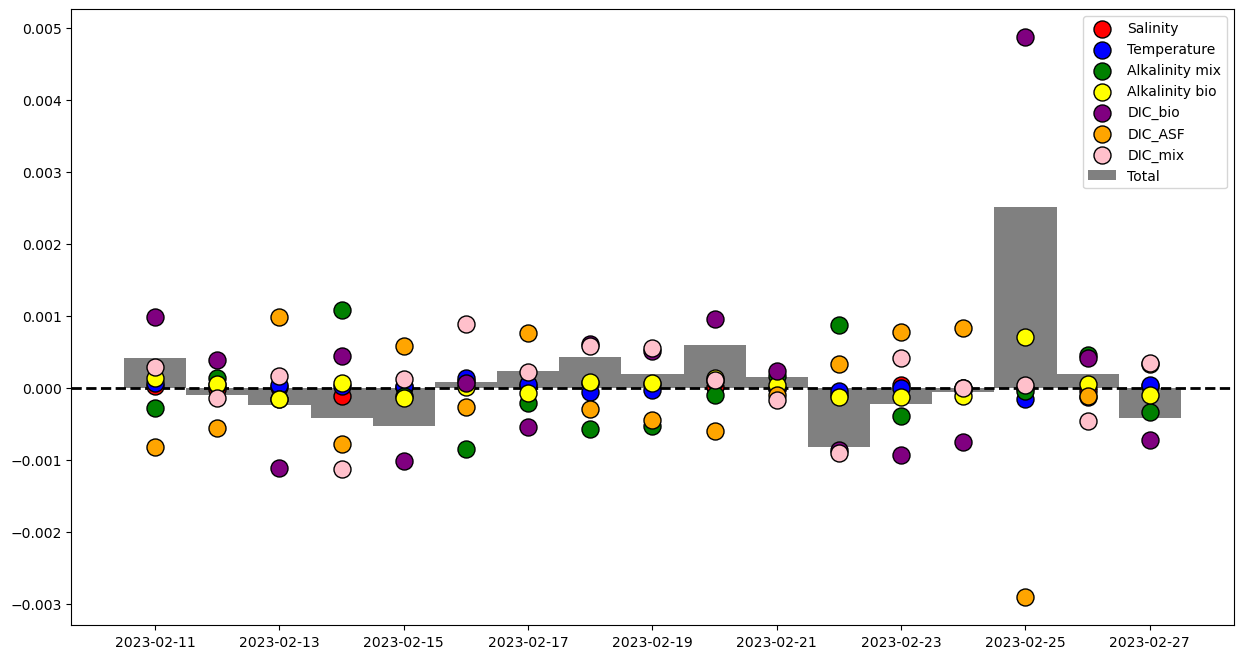

In [116]:
fig, ax = plt.subplots(figsize = [15,8])

# df.plot(x='Team', kind='bar', stacked=True,
#         title='Stacked Bar Graph by dataframe')

sal = df['∂H/∂S'] * df['∆S']
# ax.bar(H620.index, sal, width = 10, color = 'red', label = 'Salinity')
ax.scatter(df.index, sal, facecolors = 'red', edgecolors = 'k', s = 150, label = 'Salinity', zorder = 3)

temp = df['∂H/∂T'] * df['∆T']
# ax.bar(H620.index, temp+sal, bottom = sal,width = 10, color = 'blue', label = 'Temperature')
ax.scatter(df.index, temp, facecolors = 'blue', edgecolors = 'k', s = 150, label = 'Temperature', zorder = 3)

alk_mix = df['∂H/∂TA'] * df['∆TA_mix [umolC/L]']
# ax.bar(H620.index, alk, width = 10,label = 'Alkalinity')
ax.scatter(df.index, alk_mix, facecolors = 'green', edgecolors = 'k', s = 150, label = 'Alkalinity mix', zorder = 3)

alk_bio = df['∂H/∂TA'] * df['∆TA_bio [umolC/L]']
# ax.bar(H620.index, alk, width = 10,label = 'Alkalinity')
ax.scatter(df.index, alk_bio, facecolors = 'yellow', edgecolors = 'k', s = 150, label = 'Alkalinity bio', zorder = 3)

bio = df['∂H/∂DIC'] * df['∆DIC_bio [umolC/L]']
# ax.bar(H620.index, bio, width = 10,label = 'Biology')
ax.scatter(df.index, bio, facecolors = 'purple', edgecolors = 'k', s = 150, label = 'DIC_bio', zorder = 3)

ASF = df['∂H/∂DIC'] * df['∆DIC_flux [umolC/L]']
# ax.bar(H620.index, ASF, width = 10,label = 'Air Sea Flux')
ax.scatter(df.index, ASF, facecolors = 'orange', edgecolors = 'k', s = 150, label = 'DIC_ASF', zorder = 3)

mix = df['∂H/∂DIC'] * df['∆DIC_mix']
# ax.bar(H620.index, mix, width = 10,label = 'Mixing')
ax.scatter(df.index, mix, facecolors = 'pink', edgecolors = 'k', s = 150, label = 'DIC_mix', zorder = 3)

ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.bar(df.index, mix + ASF + bio + alk_bio + alk_mix + temp + sal, color = 'gray', width = 1,label = 'Total')

ax.legend()

### Errors

Supposedly, the error for each term is described by
$$
\sigma_z = z \sqrt{(\frac{\sigma_x}{x})^2 + (\frac{\sigma_y}{y})^2}
$$

For temperature:
$$
\sigma_{\text{H-T}} = z \sqrt{(\frac{\sigma_{\text{H}}}{\text{H}})^2 + (\frac{\sigma_{\text{T}}}{\text{T}})^2}
$$

For salinity:
$$
\sigma_{\text{H-S}} = z \sqrt{(\frac{\sigma_{\text{H}}}{\text{H}})^2 + (\frac{\sigma_{\text{S}}}{\text{S}})^2}
$$

For TA terms:
$$
\sigma_{\text{H-TA}} = z \sqrt{(\frac{\sigma_{\text{H}}}{\text{H}})^2 + (\frac{\sigma_{\text{TA}}}{\text{TA}})^2}
$$

For all the DIC terms:
$$
\sigma_{\text{H-DIC}} = z \sqrt{(\frac{\sigma_{\text{H}}}{\text{H}})^2 + (\frac{\sigma_{\text{DIC}}}{\text{DIC}})^2}
$$

For the total:
$$
\sqrt{\sum_{n=\text{i}} \sigma_{\text{i}}^2}
$$

# Plot with errors

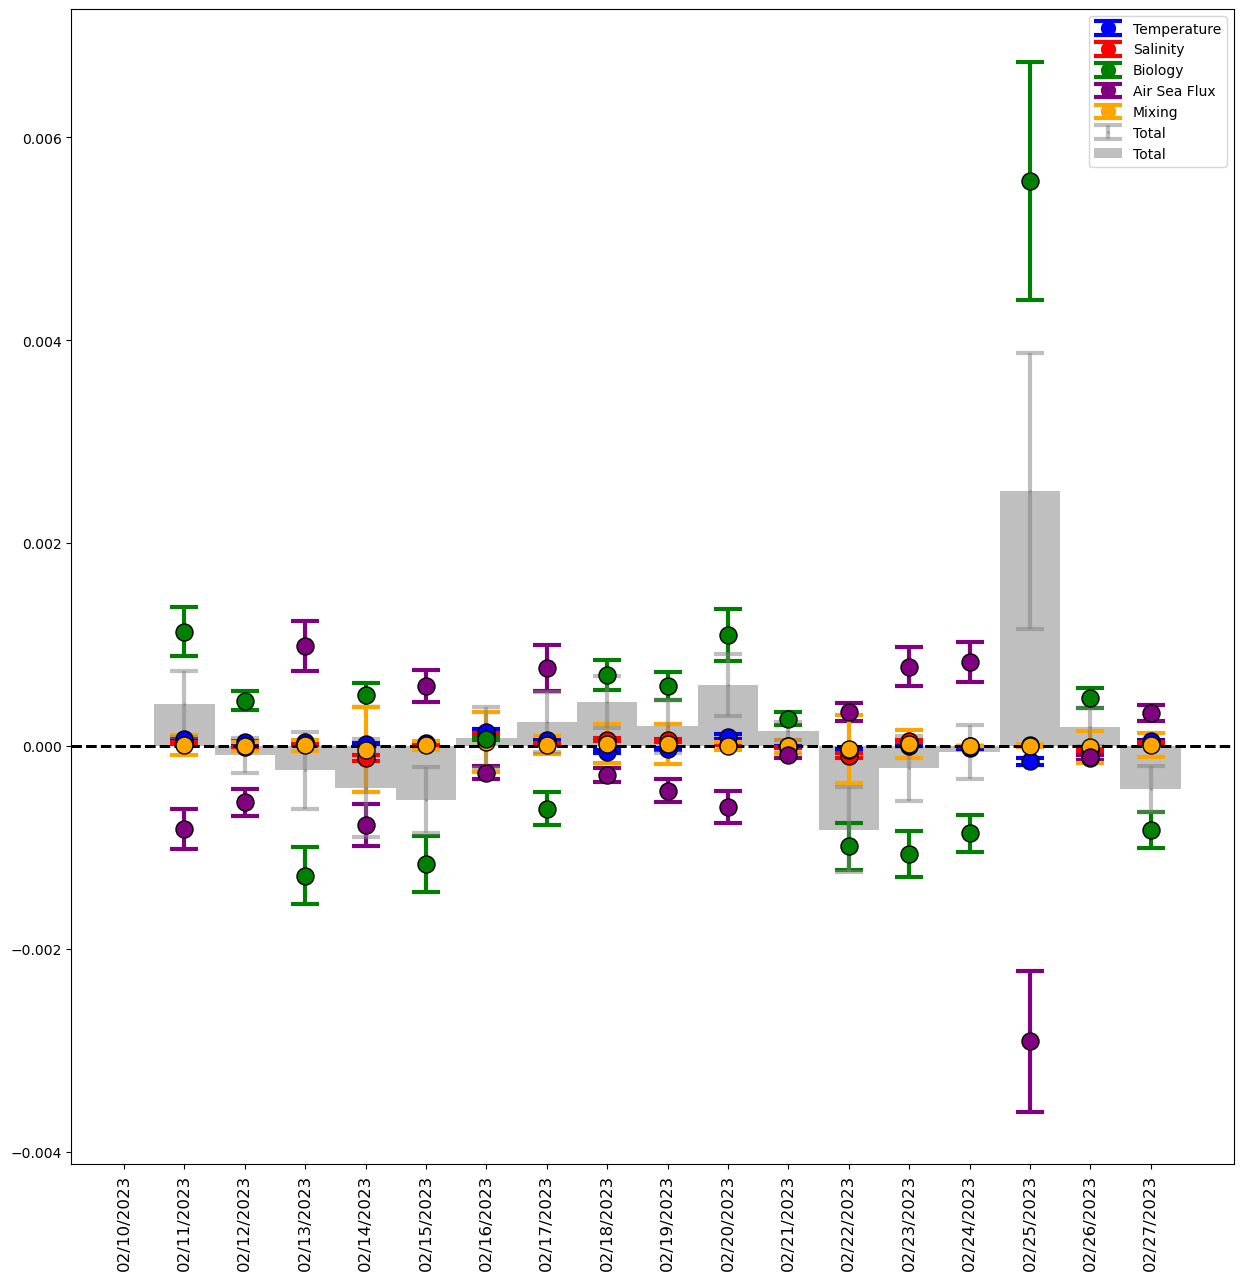

In [132]:
fig, ax = plt.subplots(figsize = [15,15])

# To calculate the total error
# each time I calculate an error for an individual component
# I will add the square to the total error
# And take the square root at the end
TOTERR = 0

# TEMPERATURE
temp = df['∂H/∂T'] * df['∆T']
YERR = temp * np.sqrt((df_std['Temperature [degC]']/df['Temperature [degC]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
ax.errorbar(df.index, temp, yerr = YERR, label = 'Temperature',
            fmt='o',capsize = 10, color = 'blue', lw = 3, capthick = 3, markersize = 10)
TOTERR += YERR**2

# SALINITY
sal = df['∂H/∂S'] * df['∆S']
YERR = sal * np.sqrt((df_std['Salinity [PSU]']/df['Salinity [PSU]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
ax.errorbar(df.index, sal, yerr = YERR, label = 'Salinity',
            fmt='o',capsize = 10, color = 'red', lw = 3, capthick = 3, markersize = 10)
TOTERR += YERR**2

# ALKALINITY MIXING (not plotted)
alk_mix = df['∂H/∂TA'] * df['∆TA_mix [umolC/L]']
YERR = alk_mix * np.sqrt((df_std['Alkalinity']/df['Alkalinity [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
TOTERR += YERR**2

# ALKALINITY BIO (not plotted)
alk_bio = df['∂H/∂TA'] * df['∆TA_bio [umolC/L]']
YERR = alk_bio * np.sqrt((df_std['Alkalinity']/df['Alkalinity [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
TOTERR += YERR**2

# DIC BIO (not plotted)
dic_bio = df['∂H/∂DIC'] * df['∆DIC_bio [umolC/L]']
YERR = dic_bio * np.sqrt((df_std['DIC [umol/kg]']/df['DIC [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
TOTERR += YERR**2

# TOTAL BIO = DIC BIO + ALK BIO
BIO = dic_bio + alk_bio
# Total bio error = sqrt(dic_bio_err^2 + alk_bio_err^2)
YERR1 = alk_bio * np.sqrt((df_std['Alkalinity']/df['Alkalinity [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
YERR2 = dic_bio * np.sqrt((df_std['DIC [umol/kg]']/df['DIC [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
YERR = np.sqrt(YERR1**2 + YERR2**2)
ax.errorbar(df.index, BIO, yerr = YERR, label = 'Biology',
            fmt='o',capsize = 10, color = 'green', lw = 3, capthick = 3, markersize = 10)

# AIR SEA FLUX
ASF = df['∂H/∂DIC'] * df['∆DIC_flux [umolC/L]']
YERR = ASF * np.sqrt((df_std['DIC [umol/kg]']/df['DIC [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
ax.errorbar(df.index, ASF, yerr = YERR, label = 'Air Sea Flux',
            fmt='o',capsize = 10, color = 'purple', lw = 3, capthick = 3, markersize = 10)
TOTERR += YERR**2

# DIC MIXING (not plotted)
dic_mix = df['∂H/∂DIC'] * df['∆DIC_mix']
YERR = dic_mix * np.sqrt((df_std['DIC [umol/kg]']/df['DIC [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
TOTERR += YERR**2

# TOTAL MIXING = DIC MIXING + ALK MIXING
# Total mix error = sqrt(dic_mix_err^2 + alk_mix_err^2)
MIX = dic_mix + alk_mix
YERR1 = alk_mix * np.sqrt((df_std['Alkalinity']/df['Alkalinity [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
YERR2 = dic_mix * np.sqrt((df_std['DIC [umol/kg]']/df['DIC [umol/kg]'])**2
        + (df_std['H+ [umol/kg]']/df['H+ [umol/kg]'])**2)
YERR = np.sqrt(YERR1**2 + YERR2**2)
ax.errorbar(df.index, MIX, yerr = YERR, label = 'Mixing',
            fmt='o', capsize = 10, color = 'orange', lw = 3, capthick = 3, markersize = 10)

# TOTAL
ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.errorbar(df.index, MIX + ASF + BIO + temp + sal, yerr = np.sqrt(TOTERR),
            label = 'Total', color = 'gray', capsize = 10, fmt = 'o', lw = 3, capthick = 3, alpha = 0.5, markersize = 1)


sal = df['∂H/∂S'] * df['∆S']
ax.scatter(df.index, sal, facecolors = 'red', edgecolors = 'k', s = 150, zorder = 3)

temp = df['∂H/∂T'] * df['∆T']
ax.scatter(df.index, temp, facecolors = 'blue', edgecolors = 'k', s = 150, zorder = 3)

alk_mix = df['∂H/∂TA'] * df['∆TA_mix [umolC/L]']
dic_mix = df['∂H/∂DIC'] * df['∆DIC_mix']
mix = dic_mix + alk_mix
ax.scatter(df.index, mix, facecolors = 'orange', edgecolors = 'k', s = 150, zorder = 3)

alk_bio = df['∂H/∂TA'] * df['∆TA_bio [umolC/L]']
dic_bio = df['∂H/∂DIC'] * df['∆DIC_bio [umolC/L]']
bio = alk_bio + dic_bio
ax.scatter(df.index, bio, facecolors = 'green', edgecolors = 'k', s = 150, zorder = 3)


ASF = df['∂H/∂DIC'] * df['∆DIC_flux [umolC/L]']
ax.scatter(df.index, ASF, facecolors = 'purple', edgecolors = 'k', s = 150, zorder = 3)

ax.axhline(y=0.0, color='k', linestyle='dashed', lw = 2)
ax.bar(df.index, mix + ASF + bio + temp + sal, color = 'gray', width = 1,label = 'Total',
      alpha = 0.5)

ax.set_xticks(df.index)
ax.set_xticklabels(df.index.strftime('%m/%d/%Y'), fontsize = 14)
ax.tick_params('x',labelsize = 12, labelrotation = 90)

ax.legend()

# ax2 = ax.twinx()
# ax3 = ax.twinx()

# ax2.plot(met2['DateTime'], met2['maximetPrecipitation'], color = 'blue')
# ax2.spines['right'].set_color('blue')
# ax2.set_ylabel('Precipitation', fontsize = 12)
# ax2.yaxis.label.set_color('blue')
# ax2.tick_params(axis='y', colors='blue')
# ax2.set_ylim([-0.5,15])

# # ax2.spines['right'].set_color('blue')
# ax3.set_ylabel('\nWind', fontsize = 12)
# ax3.yaxis.label.set_color('crimson')
# ax3.tick_params(axis='y', colors='crimson')
# ax3.plot(MET.index, MET['avgWindSpeed'], color = 'crimson')
# ax3.set_ylim([-0.75,40])

# Weather

In [133]:
df

,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Alkalinity [umol/kg],H+ [umol/kg],DIC [umol/kg],...,∆DIC,∆TA,∆T,∆S,∆DIC_mix,DIC_flux [umolC/L],∆DIC_flux [umolC/L],∆DIC_bio [umolC/L],∆TA_bio [umolC/L],∆TA_mix [umolC/L]
DateTime,,,,,,,,,,,,,,,,,,,,,
2023-02-10,3.993681,28.562519,11.568617,8.360527,0.020957,8.194335,8.008223,1962.585371,0.005740,1815.975092,...,NaN,NaN,NaN,NaN,NaN,48.251883,NaN,NaN,NaN,NaN
2023-02-11,4.319100,28.705128,11.185073,8.319690,0.022385,8.174143,7.994173,1969.999611,0.006003,1827.359539,...,11.384447,7.414241,0.325419,0.142609,7.214588,27.476169,-20.775714,24.945572,-3.730179,7.357197
2023-02-12,4.484527,28.633376,11.268469,8.320843,0.020531,8.184990,8.007736,1966.269220,0.005852,1819.294951,...,-8.064588,-3.730391,0.165427,-0.071752,-3.629938,12.792788,-14.683381,10.248732,-1.532521,-3.701690
2023-02-13,4.659867,28.720182,11.016854,8.316422,0.020490,8.190875,8.016575,1970.782277,0.005768,1819.907869,...,0.612918,4.513057,0.175340,0.086806,4.391528,39.400450,26.607662,-30.386272,4.543742,4.478334
2023-02-14,4.768154,28.045926,11.243760,8.336434,0.019979,8.229435,8.056464,1935.727695,0.005280,1775.503909,...,-44.403961,-35.054582,0.108287,-0.674256,-34.110624,15.894418,-23.506032,13.212695,-1.975730,-34.784880
2023-02-15,4.899042,28.128033,11.144990,8.340200,0.019667,8.265215,8.093935,1939.996453,0.004859,1764.662063,...,-10.841846,4.268758,0.130888,0.082107,4.153808,36.241618,20.347200,-35.342854,5.284913,4.235915
2023-02-16,5.647360,28.752295,10.461042,8.257900,0.019615,8.257900,8.099811,1972.451806,0.004921,1789.086771,...,24.424708,32.455353,0.748319,0.624261,31.581387,26.896942,-9.344676,2.187996,-0.327177,32.205649
2023-02-17,5.956225,28.893162,10.269874,8.231345,0.018242,8.231345,8.079191,1979.775498,0.005223,1803.509962,...,14.423191,7.323692,0.308865,0.140867,7.126477,51.934309,25.037367,-17.740654,2.652808,7.267345
2023-02-18,5.661174,29.241964,9.866792,8.205243,0.016722,8.205243,8.048186,1997.909703,0.005551,1830.830924,...,27.320963,18.134205,-0.295052,0.348802,17.645882,43.227615,-8.706694,18.381775,-2.748677,17.994684


In [111]:
MetData = PLT.get_buoy('2022-02-10', '2023-02-28','PLT','MetData')
metdf = pd.DataFrame (MetData) 
metdf

,TmStamp,metdataStart,avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPressure,maximetHumidity,maximetPrecipitation,maximetSolar,DateTime
0,2022-02-10T00:00:00.000Z,02/10/2022 00:00:00,1.489210,300.566,2.153110,295.029,1.4,1014.7,94,0.0,0,2022-02-10 00:00:00
1,2022-02-10T00:10:00.000Z,02/10/2022 00:10:00,0.609509,318.637,0.816639,315.335,1.4,1014.5,94,0.0,0,2022-02-10 00:10:00
2,2022-02-10T00:20:00.000Z,02/10/2022 00:20:00,1.025010,310.383,1.433140,302.321,1.2,1014.4,95,0.0,0,2022-02-10 00:20:00
3,2022-02-10T00:30:00.000Z,02/10/2022 00:30:00,0.741132,309.367,1.313290,310.330,1.3,1014.1,95,0.0,0,2022-02-10 00:30:00
4,2022-02-10T00:40:00.000Z,02/10/2022 00:40:00,0.946396,156.722,1.226670,168.000,1.2,1013.9,95,0.0,0,2022-02-10 00:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...
49554,2023-02-27T23:10:00.000Z,02/27/2023 23:10:00,6.631380,118.534,8.915070,126.921,-0.2,1012.5,74,0.0,1,2023-02-27 23:10:00
49555,2023-02-27T23:20:00.000Z,02/27/2023 23:20:00,6.727660,118.224,10.410200,109.237,0.0,1012.2,80,0.0,0,2023-02-27 23:20:00
49556,2023-02-27T23:30:00.000Z,02/27/2023 23:30:00,6.297250,123.286,9.294360,111.736,-0.6,1012.0,83,0.0,0,2023-02-27 23:30:00
49557,2023-02-27T23:40:00.000Z,02/27/2023 23:40:00,7.312270,119.869,10.774100,137.374,-1.0,1011.9,86,0.0,0,2023-02-27 23:40:00


In [148]:
type(metdf['DateTime'][0])

datetime.datetime

In [127]:

met2 = metdf.where(metdf['DateTime'] > datetime(2023, 2, 10)).where(metdf['DateTime'] < datetime(2023, 2, 28)).dropna()
MET = met2.resample('H', on='DateTime').mean()
met = met2.resample('D', on='DateTime').mean()


In [131]:
met2.where(met2['maximetPrecipitation'] > 6).dropna()

,TmStamp,metdataStart,avgWindSpeed,avgWindDir,gustWindSpeed,gustWindDir,maximetTemperature,maximetPressure,maximetHumidity,maximetPrecipitation,maximetSolar,DateTime
47425,2023-02-13T04:20:00.000Z,02/13/2023 04:20:00,8.45364,55.2490,10.44780,53.4423,3.7,1004.0,82.0,6.32,2.0,2023-02-13 04:20:00
48102,2023-02-17T21:10:00.000Z,02/17/2023 21:10:00,8.67169,333.4090,11.21000,323.0170,1.8,1006.4,94.0,6.08,1.0,2023-02-17 21:10:00
48899,2023-02-23T10:00:00.000Z,02/23/2023 10:00:00,7.38422,48.5983,9.19680,45.5806,3.5,1012.2,95.0,6.24,48.0,2023-02-23 10:00:00
48900,2023-02-23T10:10:00.000Z,02/23/2023 10:10:00,7.14559,41.3410,9.59465,55.7759,3.4,1012.1,95.0,6.16,49.0,2023-02-23 10:10:00
48912,2023-02-23T12:10:00.000Z,02/23/2023 12:10:00,7.70576,29.8447,9.57243,24.5134,3.3,1012.5,95.0,6.32,79.0,2023-02-23 12:10:00
48913,2023-02-23T12:20:00.000Z,02/23/2023 12:20:00,8.07211,32.3668,10.43460,40.7870,3.3,1012.5,94.0,6.48,98.0,2023-02-23 12:20:00


In [65]:
df

,Temperature [degC],Salinity [PSU],DO [mg/L],raw pH [total],Fluorescence [ug-chl/L],pH final,pH (normalized to 15°C),Alkalinity [umol/kg],H+ [umol/kg],DIC [umol/kg],...,∆DIC,∆TA,∆T,∆S,∆DIC_mix,DIC_flux [umolC/L],∆DIC_flux [umolC/L],∆DIC_bio [umolC/L],∆TA_bio [umolC/L],∆TA_mix [umolC/L]
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-12-20,6.340596,30.005160,9.578969,8.047478,0.145156,8.047478,7.904951,2037.588290,0.007949,1917.014458,...,NaN,NaN,NaN,NaN,NaN,2.117789,NaN,NaN,NaN,NaN
2022-12-21,6.313776,30.090338,9.611646,8.046945,0.157344,8.046945,7.903958,2042.016647,0.007959,1921.235354,...,4.220895,4.428357,-0.026820,0.085177,4.309109,2.045017,-0.072772,-0.015441,0.002309,4.394286
2022-12-22,6.182976,30.109999,9.700812,8.058984,0.123865,8.058984,7.913516,2043.038846,0.007746,1918.858706,...,-2.376648,1.022199,-0.130800,0.019661,0.994673,2.761389,0.716373,-4.087694,0.611244,1.014335
2022-12-23,6.685919,30.033073,9.558155,8.068203,0.058524,8.068203,7.931138,2039.039445,0.007565,1909.244159,...,-9.614547,-3.999400,0.502943,-0.076926,-3.891704,3.378206,0.616817,-6.339660,0.947987,-3.968630
2022-12-24,5.728175,30.056000,9.516400,8.081931,0.062417,8.081931,7.928187,2040.231440,0.007363,1911.316620,...,2.072461,1.191995,-0.957744,0.022927,1.159896,4.097117,0.718911,0.193654,-0.028958,1.182824
2022-12-25,4.920019,30.059058,9.635247,8.064311,0.077383,8.064311,7.897001,2040.390427,0.007697,1922.162482,...,10.845862,0.158987,-0.808156,0.003058,0.154705,3.004365,-1.092752,11.783908,-1.762080,0.157763
2022-12-26,4.505407,30.209624,9.791593,8.059457,0.074370,8.059457,7.885055,2048.218356,0.007797,1933.068963,...,10.906481,7.827929,-0.414611,0.150566,7.617136,2.610078,-0.394287,3.683632,-0.550823,7.767702
2022-12-27,3.672319,29.717740,10.210943,7.988943,0.082132,7.988943,7.802517,2022.645283,0.009211,1936.579289,...,3.510327,-25.573073,-0.833089,-0.491884,-24.884434,-1.893346,-4.503424,32.898185,-4.919355,-25.376319
2022-12-28,3.685986,29.532900,10.324744,7.949356,0.083419,7.949356,7.764234,2013.035471,0.010092,1939.101713,...,2.522424,-9.609812,0.013667,-0.184840,-9.351037,-4.753992,-2.860646,14.734107,-2.203231,-9.535876
